In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler

In [18]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    plt.figure(figsize=(10, 7))
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    # disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    # disp.plot()    
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",cbar=False, xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [19]:

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(figsize=(10, 6))
        
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    
    # Extract mean and standard deviation from the learning curve results
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)


    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    axes.plot(train_sizes, train_scores_mean, label="Training score")
    axes.plot(train_sizes, test_scores_mean, label="Validation score")
    axes.set_title(title)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")
    axes.legend(loc="best")
    if ylim is not None:
        axes.set_ylim(*ylim)

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )


    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)


    plt.figure(figsize=(10, 6))
    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel(f"Score ({scoring})")
    plt.plot(param_range, train_scores_mean, label="Training score")
    plt.plot(param_range, test_scores_mean, label="Validation score")
    plt.legend(loc="best")
    plt.show()


def plot_validation_curve_fin(clf, X_train, y_train, param_name, cv):
    # Define the hyperparameter range
    param_range = np.arange(1, 21)

    # Calculate training and validation scores over the specified hyperparameter range
    train_scores, test_scores = validation_curve(
        clf, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title('Model Complexity Graph')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()    

In [20]:
models = []
# Load the dataset
file_path = "jobs_in_data.csv"
df = pd.read_csv(file_path)

# Convert 'salary_in_usd' to categories
df['salary_usd_group'] = pd.cut(
    df['salary_in_usd'],
    bins=[0, 50_000, 100_000, 200_000, 300_000, 400_000, 500_000],
    labels=['0-50K', '50k-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k']
)

# Encode categorical variables
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Separate features and target
X = df.drop(['salary', 'salary_in_usd'], axis=1)
y = df['salary_usd_group']

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Creating transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Use ColumnTransformer to apply transformers to specific feature columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# # Use RandomOverSampler to oversample minority classes
# oversampler = RandomOverSampler(random_state=42)
# X, y = oversampler.fit_resample(X, y)


In [21]:
class_counts=y.value_counts()
print(class_counts)

salary_usd_group
100k-200k    2642
50k-100k     1772
200k-300k    1630
0-50K         344
300k-400k     178
400k-500k       8
Name: count, dtype: int64


In [22]:
class_ratios=class_counts/len(y)
print(class_ratios)

salary_usd_group
100k-200k    0.401886
50k-100k     0.269547
200k-300k    0.247946
0-50K        0.052327
300k-400k    0.027076
400k-500k    0.001217
Name: count, dtype: float64


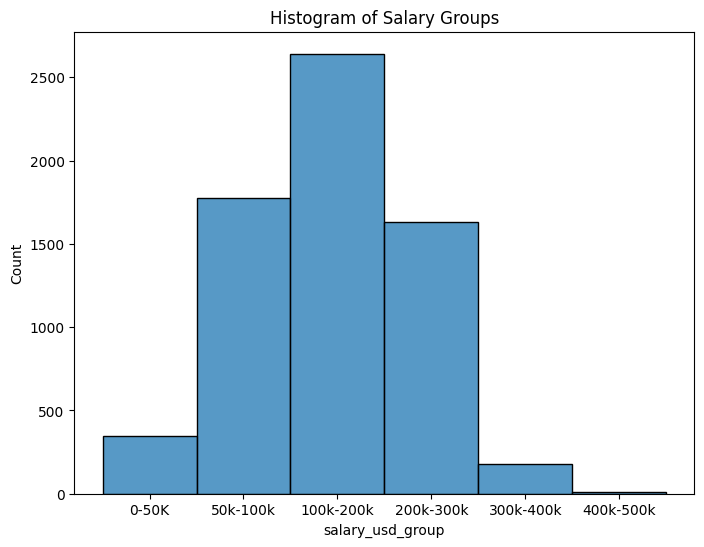

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(data=X, x='salary_usd_group', bins=10)
plt.title('Histogram of Salary Groups')

plt.show()

--------------------------------------------------------------------------------

MODEL: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['salary_usd_group']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['work_year', 'job_title',
                                                   'job_category',
                                                   'salary_currency',
                                                   'employee_resi

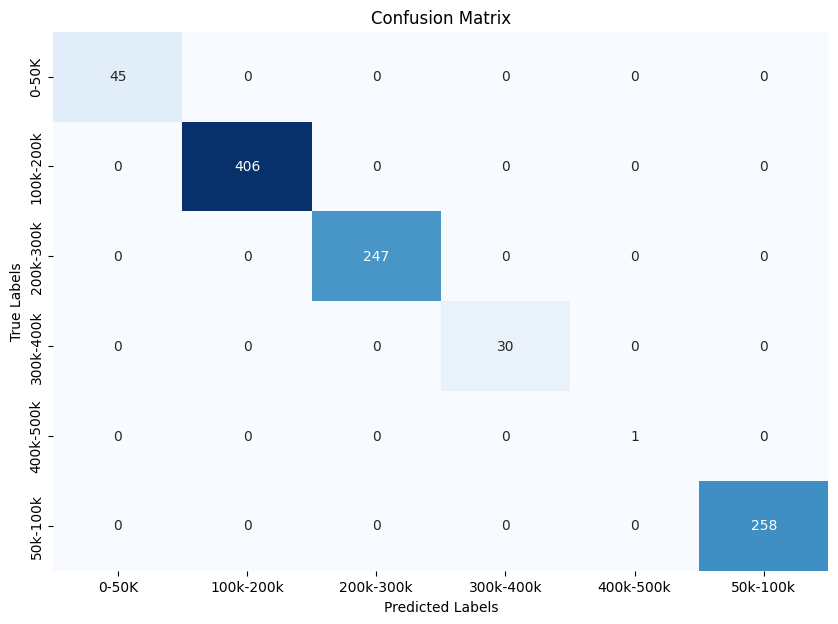

[*] Test Accuracy: 100.0%
--------------------------------------------------------------------------------



<Figure size 1000x600 with 0 Axes>

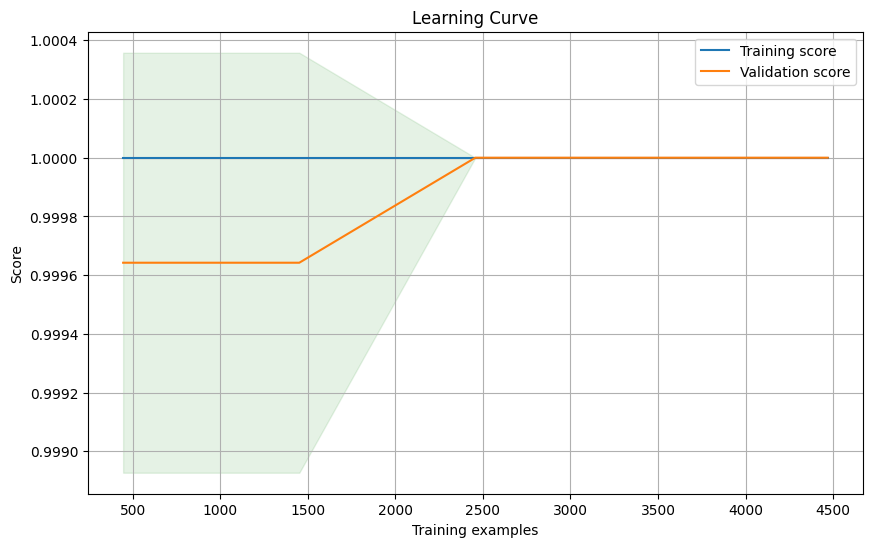

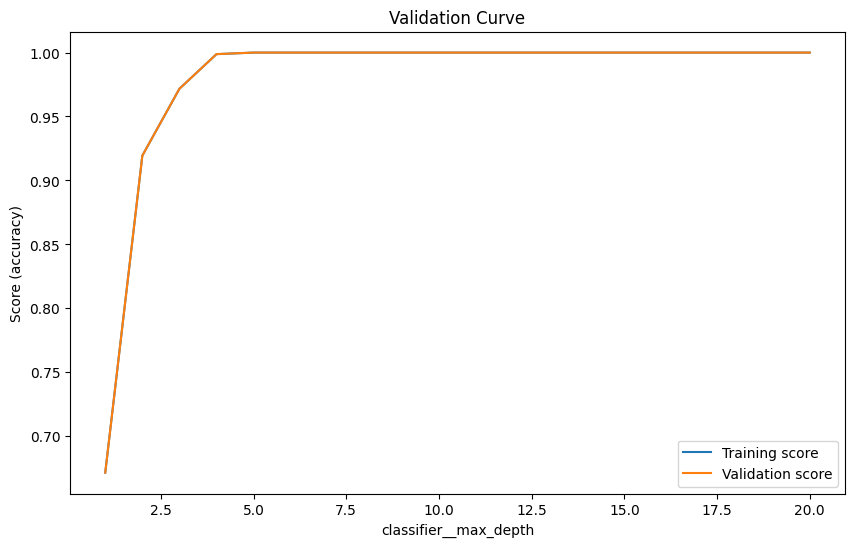

Accuracy on Test Set: 1.0000
--------------------------------------------------------------------------------

MODEL: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['salary_usd_group']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['work_year', 'job_title',
                                                   'job_category',
                                                   'salary_currency',
                                    

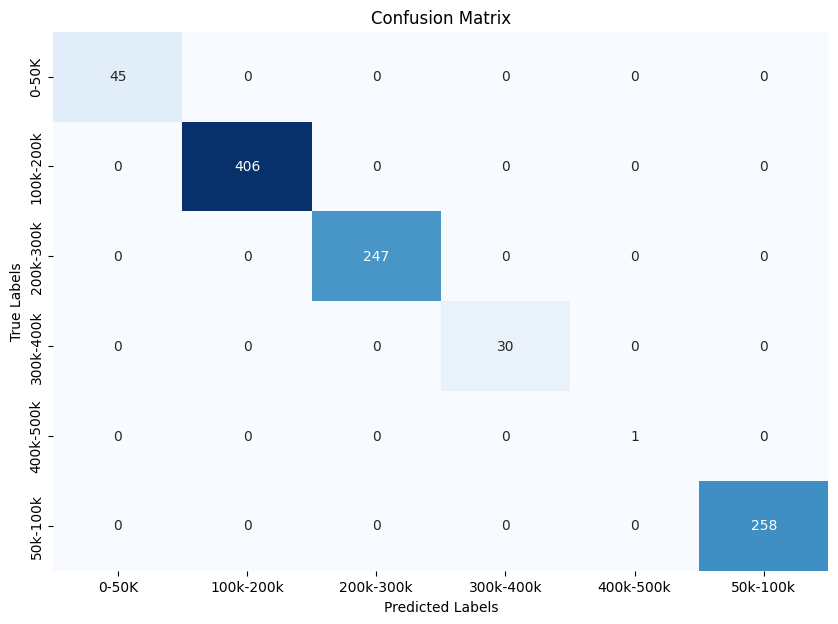

[*] Test Accuracy: 100.0%
--------------------------------------------------------------------------------

Total time taken : 0.03 seconds


In [24]:
import time
# Split the data into training and testing sets

start_time = time.time()
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)

# Train the model using the pipeline
clf.fit(X_train, y_train)

end_time = time.time()
# Make predictions on the test set
get_accuracy(clf)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=StratifiedKFold(n_splits=5))
plt.show()

# Plot Validation Curve
param_range = np.arange(1, 21)
param_name = "classifier__max_depth"
train_scores, test_scores = validation_curve( clf, X, y, param_name=param_name, param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Validation Curve")
plt.xlabel(f"{param_name}")
plt.ylabel(f"Score (accuracy)")
plt.plot(param_range, train_scores_mean, label="Training score")
plt.plot(param_range, test_scores_mean, label="Validation score")
plt.legend(loc="best")
plt.show()

# Fit the final model with the optimal max_depth
optimal_max_depth = param_range[np.argmax(np.mean(test_scores, axis=1))]
final_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=optimal_max_depth, random_state=42))
])
final_clf.fit(X_train, y_train)

# Evaluate on the test set
y_pred = final_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)

print(f"Accuracy on Test Set: {accuracy:.4f}")
# print(f"F1 Score on Test Set: {f1:.4f}")

get_accuracy(clf)

total_time = end_time - start_time
print(f"Total time taken : {total_time:.2f} seconds")   

--------------------------------------------------------------------------------

MODEL: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['salary_usd_group']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['work_year', 'job_title',
                                                   'job_category',
                                                   'salary_currency',
                                                   'employee_resi

[*] Train Score: 1.0
[*] Test Score: 1.0

[*] Test Classification Report: 
               precision    recall  f1-score   support

       0-50K       1.00      1.00      1.00       355
   100k-200k       1.00      1.00      1.00       390
   200k-300k       1.00      1.00      1.00       399
   300k-400k       1.00      1.00      1.00       436
   400k-500k       1.00      1.00      1.00       399
    50k-100k       1.00      1.00      1.00       399

    accuracy                           1.00      2378
   macro avg       1.00      1.00      1.00      2378
weighted avg       1.00      1.00      1.00      2378

[*] Confusion Matrix on Test data


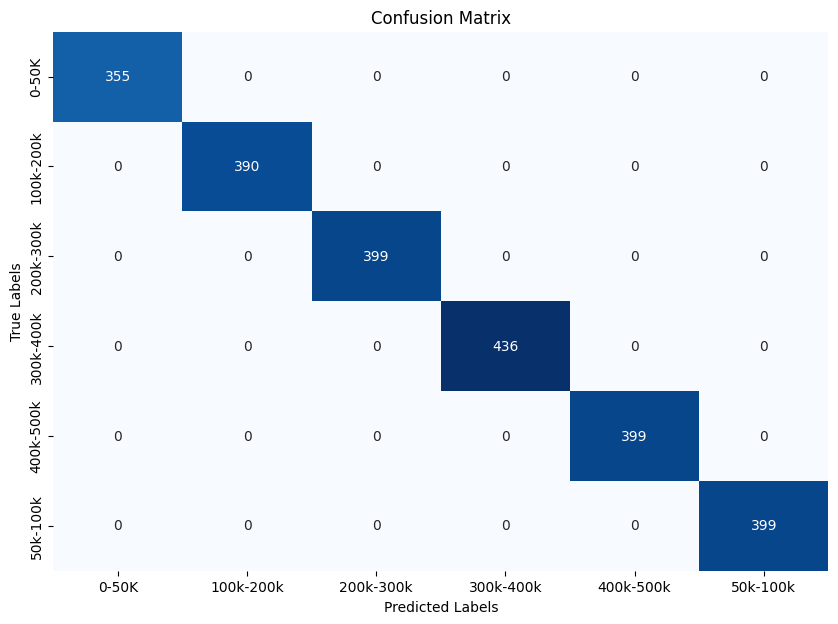

[*] Test Accuracy: 100.0%
--------------------------------------------------------------------------------

CPU times: total: 188 ms
Wall time: 189 ms


In [9]:
%%time

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=13)

# Train the model using the pipeline
clf.fit(X_train, y_train)

# Make predictions on the test set
get_accuracy(clf)


<Figure size 1000x600 with 0 Axes>

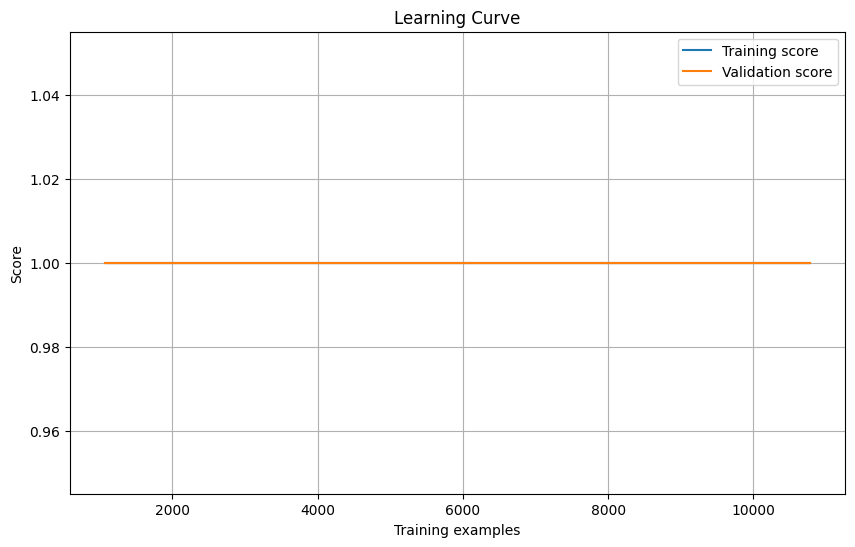

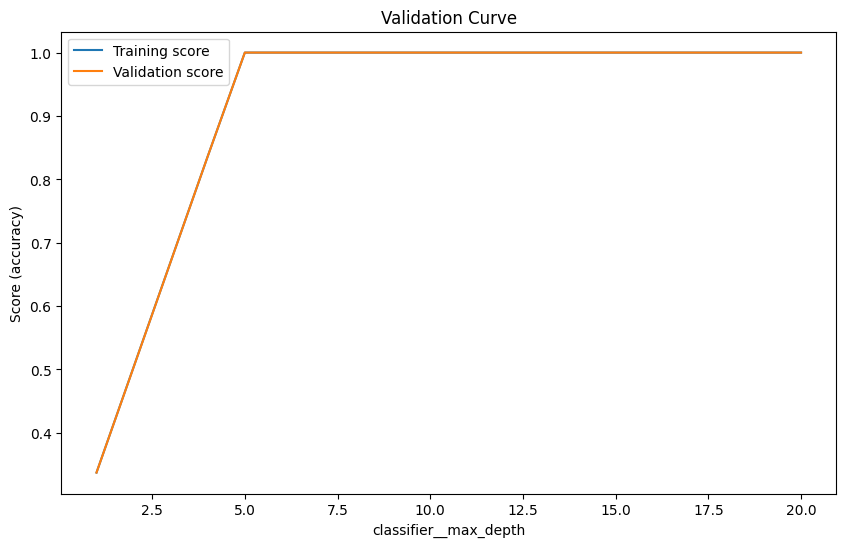

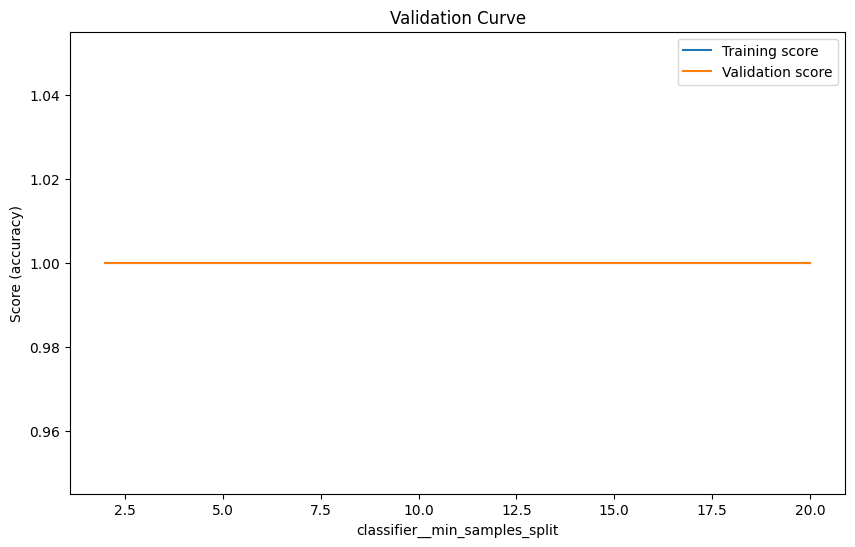

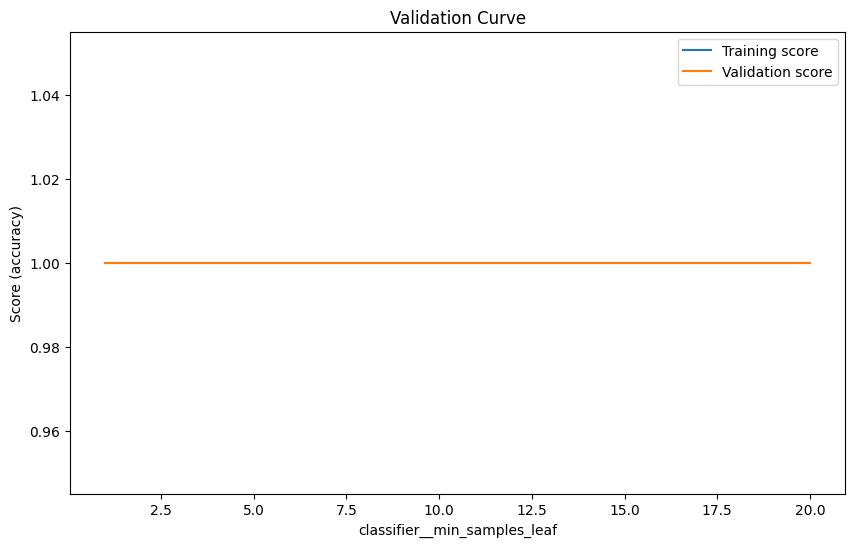

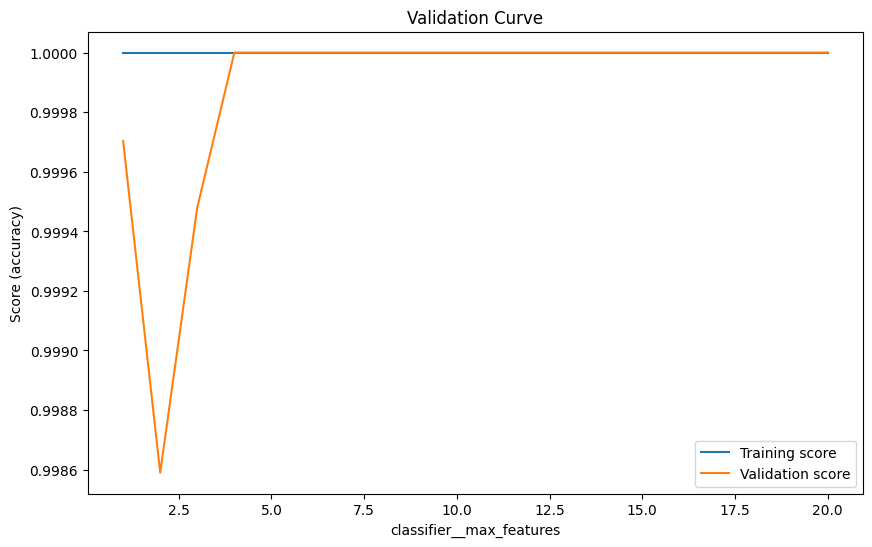

In [14]:
train_sizes = np.linspace(0.1, 1.0, 10)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plot_learning_curve(clf, "Learning Curve", X_train, y_train, cv=StratifiedKFold(n_splits=5))
plt.show()

# Plot the Validation curve

# plot_validation_curve_fin(clf,X_train, y_train,'max_depth', cv=5)
plot_validation_curve(clf,X_train, y_train,param_range=param_range, param_name="classifier__max_depth", cv=5, scoring="accuracy")
plot_validation_curve(clf,X_train, y_train,param_range=param_range, param_name="classifier__min_samples_split", cv=5, scoring="accuracy")
plot_validation_curve(clf,X_train, y_train,param_range=param_range, param_name="classifier__min_samples_leaf", cv=5, scoring="accuracy")
plot_validation_curve(clf,X_train, y_train,param_range=param_range, param_name="classifier__max_features", cv=5, scoring="accuracy")

In [11]:
%%time

param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [None, 'sqrt', 'log2']
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator from GridSearchCV
clf_gs = grid_search.best_estimator_

# Evaluate the model selected by GridSearchCV on the test set
y_pred_gs = clf_gs.predict(X_test)

# Decode the predictions if needed
# y_pred_decoded_gs = le.inverse_transform(y_pred_gs)

# Evaluate the model
accuracy_gs = accuracy_score(y_test, y_pred_gs)
f1_gs = f1_score(y_test, y_pred_gs, average='weighted')

print(f"GridSearchCV Model - Accuracy on Test Set: {accuracy_gs:.4f}")
print(f"GridSearchCV Model - F1 Score on Test Set: {f1_gs:.4f}")

# Additional details from GridSearchCV
print("GridSearchCV Best Parameters:")
print(grid_search.best_params_)

GridSearchCV Model - Accuracy on Test Set: 1.0000
GridSearchCV Model - F1 Score on Test Set: 1.0000
GridSearchCV Best Parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
CPU times: total: 5.14 s
Wall time: 10.1 s
